### Imports

In [145]:
import numpy as np
import pandas as pd

from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

import wordninja

In [3]:
def fetch_training_data():
    return pd.read_csv('train_set.csv', encoding='latin-1')

def fetch_test_data():
    return pd.read_csv('test_set.csv', encoding='latin-1')

In [4]:
#Separates feature and target variables.
def feature_target_separator(df):
    feature = df.iloc[:,1]
    target = df.iloc[:,0]
    return feature, target

In [74]:
def split_joint_text(tokens):
    lm = wordninja.LanguageModel('text.txt.gz')
    
    for each_token in tokens:
        temp_list = lm.split(each_token)
        temp_list = list(filter(lambda x: len(x)>1,temp_list))
        if len(temp_list)> 1:
            #print(temp_list)
            tokens.remove(each_token)
            tokens.extend(temp_list)
    
    return tokens

In [97]:
def preprocess(input_sentence, stem=False, to_split_text=False):
    tokenizer_obj= TreebankWordTokenizer()
    stemmer_obj = PorterStemmer()
    
    ## Removing punctuations and special characters
    input_sentence = input_sentence.lower()
    clean_text = re.sub(r"[^a-z0-9]", ' ', input_sentence)
    
    ## Tokenizing text
    tokens = tokenizer_obj.tokenize(clean_text)
    if stem:
        tokens = [stemmer_obj.stem(x) for x in tokens]
    
    ## Splitting joint words (For eg. partsfor, forcaptive)
    if to_split_text:
        tokens = split_joint_text(tokens)
    
    ## Removing all tokens of length less than 3
    stop_words = stopwords.words("english")
    clean_tokens = [word for word in tokens if word not in stop_words]
    filtered_tokens = list(filter(lambda x: len(x)>2, clean_tokens))
    processed_sentence = ' '.join(filtered_tokens)
    
    return processed_sentence

In [43]:
def build_model(data, target, estimator):
    model = estimator
    
    pipeline = Pipeline([('tf-idf',TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5, norm='l1')),
                         ('clf',estimator),])
    
    pipeline.fit(data, target)
    
    return pipeline

In [110]:
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print('Subset accuracy is {}'.format(accuracy_score(y_test, y_pred)))
    
    cv_score = cross_val_score(model, x_test, y_test, cv=5)
    print("Cross validation scores {}".format(cv_score))
    print("Mean Cross validation score {}".format(cv_score.mean()))
    print(classification_report(y_test, y_pred))

In [70]:
train_data = fetch_training_data()
train_features, train_target = feature_target_separator(train_data)

## EDA

In [125]:
def get_tokens(input_ls):
    tokenizer_obj= TreebankWordTokenizer()
    input_ls = [x.lower() for x in input_ls]
    tokens = [tokenizer_obj.tokenize(x) for x in input_ls]
    
    return tokens

In [131]:
list_of_tokens = get_tokens(train_features)

In [135]:
'''
This is to check how many of single character tokens are there in the training set.
Single characters make the document ambiguous and might reduce the predictability.
Hence if there are large number of single characters, it is to be removed.
'''
main_token_list = []
for doc in list_of_tokens:
    doc_list = []
    for token in doc:
        if len(token) == 1:
            doc_list.append(token)
    main_token_list.append(doc_list)

main_token_list = [i for i in main_token_list if len(i)>0]
single_char_token = pd.DataFrame(main_token_list)
single_char_token[0].value_counts()

g    2254
a    1505
b    1033
p     923
r     642
x     640
m     471
v     459
l     276
s     253
c     253
w     221
t     192
d     189
k     186
f     179
h     153
n     149
e     131
q     115
i      84
y      55
u      43
z      32
o      18
j      16
Name: 0, dtype: int64

In [143]:
'''
As we can see that there are a lot of single characters and have to me removed. Similarly we also check if there are
2 letter words in the data set. if these words do not have linguistic significance, they should be removed.
'''
main_token_list = []
for doc in list_of_tokens:
    doc_list = []
    for token in doc:
        if len(token) == 2:
            doc_list.append(token)
    main_token_list.append(doc_list)

main_token_list = [i for i in main_token_list if len(i)>0]
double_char_token = pd.DataFrame(main_token_list)
print("Total unique 2 letter words are {}".format(len(double_char_token[0].unique())))
double_char_token[0].value_counts().head(10)

Total unique 2 letter words are 486


no    2177
of     837
sl     818
to     511
mm     441
ac     402
hp     363
kw     306
sr     288
st     280
Name: 0, dtype: int64

## Building Model

- Stemming = False, Split Text = False

In [115]:
'''
Preprocessing the training data
- Tokenizing, Not Stemming and Keeping the joint words as it is
- This is part of cleaning the data

Using the cleaned text for modelling.
- creating vectors using tf-idf with ngrams 1 and 2 words
- Using Naive Bayes model for prediction.
'''

X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, random_state=10)
X_train = X_train.apply(preprocess, stem=False, to_split_text=False)
model = build_model(X_train, y_train, MultinomialNB())
X_test = X_test.apply(preprocess, stem=False, to_split_text=False)
evaluate_model(model, X_test, y_test)

Subset accuracy is 0.8665311653116531
Cross validation scores [0.80609653 0.76037257 0.76883997 0.78662151 0.79915254]
Mean Cross validation score 0.7842166219377431
              precision    recall  f1-score   support

    33041000       1.00      1.00      1.00       426
    39269099       0.90      0.67      0.77       557
    73181500       0.90      0.86      0.88       471
    84713010       1.00      0.93      0.96       352
    85177090       0.88      0.96      0.92       633
    85238090       0.99      0.97      0.98       427
    85364900       0.91      0.95      0.93       413
    85366990       0.91      0.70      0.79       485
    85369090       0.82      0.84      0.83       619
    85389000       0.68      0.95      0.79       753
    87082900       0.94      0.80      0.86       362
    87089900       0.82      0.75      0.78       406

    accuracy                           0.87      5904
   macro avg       0.89      0.87      0.87      5904
weighted avg       0.8

- Stemming = True, Split Text = False

In [118]:
'''
Testing if Stemming improves the performance.
'''

X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, random_state=10)
X_train = X_train.apply(preprocess, stem=True, to_split_text=False)
model = build_model(X_train, y_train, MultinomialNB())
X_test = X_test.apply(preprocess, stem=True, to_split_text=False)
evaluate_model(model, X_test, y_test)

Subset accuracy is 0.8683943089430894
Cross validation scores [0.80524979 0.75613887 0.77900085 0.78323455 0.80932203]
Mean Cross validation score 0.7865892162631496
              precision    recall  f1-score   support

    33041000       1.00      1.00      1.00       426
    39269099       0.90      0.69      0.79       557
    73181500       0.92      0.85      0.89       471
    84713010       1.00      0.93      0.96       352
    85177090       0.89      0.97      0.93       633
    85238090       0.99      0.97      0.98       427
    85364900       0.91      0.95      0.93       413
    85366990       0.92      0.68      0.78       485
    85369090       0.80      0.84      0.82       619
    85389000       0.68      0.95      0.79       753
    87082900       0.94      0.80      0.86       362
    87089900       0.82      0.77      0.79       406

    accuracy                           0.87      5904
   macro avg       0.90      0.87      0.88      5904
weighted avg       0.8

- Stemming = True, Split Text = True

In [119]:
'''
Stemming and splitting the joint words.
'''

X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, random_state=10)
X_train = X_train.apply(preprocess, stem=True, to_split_text=True)
model = build_model(X_train, y_train, MultinomialNB())
X_test = X_test.apply(preprocess, stem=True, to_split_text=True)
evaluate_model(model, X_test, y_test)

Subset accuracy is 0.8689024390243902
Cross validation scores [0.80524979 0.75613887 0.77815411 0.78323455 0.81016949]
Mean Cross validation score 0.7865893597784124
              precision    recall  f1-score   support

    33041000       1.00      1.00      1.00       426
    39269099       0.90      0.70      0.79       557
    73181500       0.92      0.85      0.89       471
    84713010       1.00      0.93      0.96       352
    85177090       0.89      0.97      0.93       633
    85238090       0.99      0.97      0.98       427
    85364900       0.91      0.95      0.93       413
    85366990       0.92      0.68      0.78       485
    85369090       0.80      0.84      0.82       619
    85389000       0.68      0.95      0.79       753
    87082900       0.94      0.80      0.86       362
    87089900       0.82      0.77      0.79       406

    accuracy                           0.87      5904
   macro avg       0.90      0.87      0.88      5904
weighted avg       0.8

In [121]:
'''
Tuning the model by changing alpha which is the smoothing factor.

'''
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, random_state=10)
X_train = X_train.apply(preprocess, stem=True, to_split_text=True)
model = build_model(X_train, y_train, MultinomialNB(alpha=0.4))
X_test = X_test.apply(preprocess, stem=True, to_split_text=True)
evaluate_model(model, X_test, y_test)

Subset accuracy is 0.9009146341463414
Cross validation scores [0.85605419 0.82387807 0.83573243 0.83996613 0.84576271]
Mean Cross validation score 0.8402787066404512
              precision    recall  f1-score   support

    33041000       1.00      1.00      1.00       426
    39269099       0.88      0.79      0.83       557
    73181500       0.92      0.87      0.90       471
    84713010       1.00      0.99      0.99       352
    85177090       0.92      0.97      0.94       633
    85238090       0.99      0.97      0.98       427
    85364900       0.93      0.96      0.94       413
    85366990       0.91      0.77      0.84       485
    85369090       0.84      0.87      0.86       619
    85389000       0.80      0.93      0.86       753
    87082900       0.93      0.85      0.89       362
    87089900       0.85      0.84      0.85       406

    accuracy                           0.90      5904
   macro avg       0.91      0.90      0.91      5904
weighted avg       0.9

In [122]:
'''
Changing the model and testing with RandomForest
'''
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, random_state=10)
X_train = X_train.apply(preprocess, stem=True, to_split_text=True)
model = build_model(X_train, y_train, RandomForestClassifier(n_estimators=100))
X_test = X_test.apply(preprocess, stem=True, to_split_text=True)
evaluate_model(model, X_test, y_test)

Subset accuracy is 0.9310636856368564
Cross validation scores [0.88653683 0.86113463 0.87129551 0.84928027 0.88559322]
Mean Cross validation score 0.8707680936867636
              precision    recall  f1-score   support

    33041000       1.00      1.00      1.00       426
    39269099       0.85      0.87      0.86       557
    73181500       0.87      0.94      0.90       471
    84713010       0.99      0.98      0.98       352
    85177090       0.97      0.96      0.97       633
    85238090       1.00      0.98      0.99       427
    85364900       0.97      0.99      0.98       413
    85366990       0.90      0.88      0.89       485
    85369090       0.92      0.88      0.90       619
    85389000       0.92      0.93      0.92       753
    87082900       0.91      0.92      0.92       362
    87089900       0.91      0.88      0.90       406

    accuracy                           0.93      5904
   macro avg       0.93      0.93      0.93      5904
weighted avg       0.9

- At this point, we can see that we are getting better performance with RandomForest without drop in cross validation score, which indicates that the model is not overfitting

## Hyperparameter tuning

In [144]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, random_state=10)
X_train = X_train.apply(preprocess, stem=True, to_split_text=True)

In [150]:
from sklearn.pipeline import make_pipeline

In [163]:
n_est = [50,100,150,200,300,350,400]

<AxesSubplot:xlabel='n_estimators'>

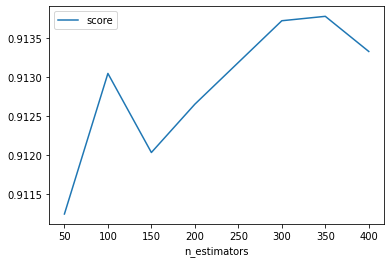

In [164]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5, norm='l1'),
                     RandomForestClassifier())
gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'randomforestclassifier__n_estimators':n_est
    },
    scoring='accuracy',
    cv=3
)
grid_result = gsc.fit(X_train, y_train)

d = pd.DataFrame({'score':grid_result.cv_results_['mean_test_score'],
                  'n_estimators':n_est
                 })
d.plot(x='n_estimators')

In [168]:
max_depths = [5,10,15,30,50,100,150,200]

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END randomforestclassifier__max_depth=5;, score=0.572 total time=   1.7s
[CV 2/3] END randomforestclassifier__max_depth=5;, score=0.608 total time=   1.7s
[CV 3/3] END randomforestclassifier__max_depth=5;, score=0.579 total time=   1.7s
[CV 1/3] END randomforestclassifier__max_depth=10;, score=0.678 total time=   2.0s
[CV 2/3] END randomforestclassifier__max_depth=10;, score=0.681 total time=   2.0s
[CV 3/3] END randomforestclassifier__max_depth=10;, score=0.683 total time=   2.0s
[CV 1/3] END randomforestclassifier__max_depth=15;, score=0.731 total time=   2.8s
[CV 2/3] END randomforestclassifier__max_depth=15;, score=0.725 total time=   2.4s
[CV 3/3] END randomforestclassifier__max_depth=15;, score=0.726 total time=   2.5s
[CV 1/3] END randomforestclassifier__max_depth=30;, score=0.798 total time=   5.2s
[CV 2/3] END randomforestclassifier__max_depth=30;, score=0.787 total time=   4.6s
[CV 3/3] END randomforestclass

<AxesSubplot:xlabel='max_depth'>

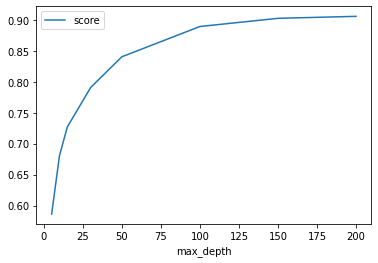

In [169]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5, norm='l1'),
                     RandomForestClassifier(n_estimators=300))
gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'randomforestclassifier__max_depth':max_depths
    },
    scoring='accuracy',
    cv=3,
    verbose=6
)
grid_result = gsc.fit(X_train, y_train)

d = pd.DataFrame({'score':grid_result.cv_results_['mean_test_score'],
                  'max_depth':max_depths
                 })
d.plot(x='max_depth')

In [170]:
min_sample_splits = [2,5,8,10]

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END randomforestclassifier__min_samples_split=2;, score=0.904 total time=  18.6s
[CV 2/3] END randomforestclassifier__min_samples_split=2;, score=0.900 total time=  18.4s
[CV 3/3] END randomforestclassifier__min_samples_split=2;, score=0.906 total time=  18.6s
[CV 1/3] END randomforestclassifier__min_samples_split=5;, score=0.903 total time=  14.6s
[CV 2/3] END randomforestclassifier__min_samples_split=5;, score=0.900 total time=  14.7s
[CV 3/3] END randomforestclassifier__min_samples_split=5;, score=0.906 total time=  14.6s
[CV 1/3] END randomforestclassifier__min_samples_split=8;, score=0.903 total time=  12.1s
[CV 2/3] END randomforestclassifier__min_samples_split=8;, score=0.900 total time=  11.9s
[CV 3/3] END randomforestclassifier__min_samples_split=8;, score=0.902 total time=  12.2s
[CV 1/3] END randomforestclassifier__min_samples_split=10;, score=0.899 total time=  11.8s
[CV 2/3] END randomforestclassifier__mi

<AxesSubplot:xlabel='min_samples_split'>

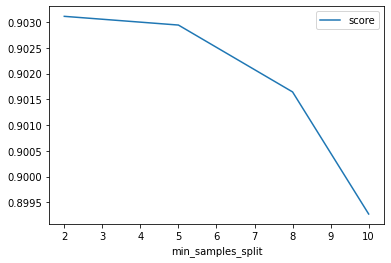

In [171]:
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.5, norm='l1'),
                     RandomForestClassifier(n_estimators=300, max_depth=150))
gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'randomforestclassifier__min_samples_split':min_sample_splits
    },
    scoring='accuracy',
    cv=3,
    verbose=6
)
grid_result = gsc.fit(X_train, y_train)

d = pd.DataFrame({'score':grid_result.cv_results_['mean_test_score'],
                  'min_samples_split':min_sample_splits
                 })
d.plot(x='min_samples_split')

In [184]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, random_state=10)
X_train = X_train.apply(preprocess, stem=True, to_split_text=True)
model = build_model(X_train, y_train, RandomForestClassifier(n_estimators=300,max_depth=150))
X_test = X_test.apply(preprocess, stem=True, to_split_text=True)
evaluate_model(model, X_test, y_test)

Subset accuracy is 0.915819783197832
Cross validation scores [0.88060965 0.85859441 0.85605419 0.84081287 0.87711864]
Mean Cross validation score 0.8626379540464129
              precision    recall  f1-score   support

    33041000       1.00      1.00      1.00       426
    39269099       0.68      0.90      0.78       557
    73181500       0.94      0.88      0.91       471
    84713010       0.99      0.97      0.98       352
    85177090       0.97      0.95      0.96       633
    85238090       1.00      0.97      0.99       427
    85364900       0.98      0.98      0.98       413
    85366990       0.91      0.85      0.88       485
    85369090       0.92      0.87      0.89       619
    85389000       0.91      0.91      0.91       753
    87082900       0.94      0.88      0.91       362
    87089900       0.92      0.85      0.89       406

    accuracy                           0.92      5904
   macro avg       0.93      0.92      0.92      5904
weighted avg       0.92

## Prediction on test data

In [190]:
test_data = fetch_test_data()

In [191]:
test_data_processed = test_data.text.apply(preprocess, stem=True, to_split_text=True)

In [192]:
test_data['prediction'] = model.predict(test_data_processed)

In [194]:
test_data.to_csv('test_data_with_preds.csv')